<a href="https://colab.research.google.com/github/vn322/Cod_future/blob/main/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Рекомендательная система

Рекомендательная система (recommender system) стремится максимально точно предсказать предпочтения потребителя и предложить наиболее подходящий товар или услугу.

Сегодня такие системы встречаются повсеместно. Практически любой крупный интернет-магазин, онлайн-кинотеатр или новостной портал использует ту или иную рекомендательную систему для того, чтобы предоставить пользователям то, что им действительно нужно.

Рассмотрим основные типы рекомендательных систем, а затем создадим свою рекомендательную систему для онлайн-кинотеатра. Итак, начнем.

Типы рекомендательных систем
Для простоты выделим три типа рекомендательных систем: фильтрация по популярности, на основе содержания и коллаборативная система.

Наиболее простая система выдает рекомендации на основе популярности (popularity-based recommender systems). Чем выше средний рейтинг фильма, купленного товара или статьи, тем вероятнее, что система будет рекомендовать именно их.

Преимуществом является простота, недостатком то, что не учитываются предпочтения конкретного пользователя.

Вторым типом рекомендательных систем является, так называемая, фильтрация на основе содержания (content-based filtering). В данном случае алгоритм рекомендует товары или услуги, схожие с теми, которые пользователь приобретал ранее. Например, если вы посмотрели фильм «Матрица» с Киану Ривзом, то в дальнейшем система будет рекомендовать вам  фантастику, а также другие фильмы с участием этого актера.

Такую систему также несложно реализовать, при этом основным недостатком будет то, что покупатели не пробуют новые товары или услуги.

Третий тип — коллаборативная система (collaborative filtering). Именно ей мы и будем сегодня заниматься. Она основывается на сопоставлении пользователей и товаров (или услуг, новостей и т.д.). Математически и графически в данном случае мы работаем с матрицами предпочтений (user-item matrix).

Существует два вида таких систем.

Коллаборативные системы, основанные на пользователях (user-based), находят близких по предпочтениям пользователей и рекомендуют одному из них то, что уже попробовал другой.

Системы, основанные на предмете рекомендации (item-based), сравнивают непосредственно близость товаров или услуг. Причем что отличает эту систему, сходство определяется на основе предпочтений всех пользователей, которые оставили свои оценки.

на первом этапе, нам нужно подготовить данные, то есть создать матрицу предпочтений, где строками будут фильмы, столбцами — пользователи, а элементами — рейтинги.

На втором этапе, мы рассчитаем расстояния от каждого фильма до ближайших векторов (других фильмов).

Для этого мы будем использовать алгоритм k-ближайших соседей (k-nearest neighbors algorithm, k-NN).

На третьем этапе, возьмем картину, для которой хотим подобрать рекомендации, и найдем в базе данных фильмы с наибольшим косинусным сходством.

### Этап 1. Подготовка данных

In [1]:
# эти библиотеки нам уже знакомы
import pandas as pd
import numpy as np

# модуль sparse библиотеки scipy понадобится 
# для работы с разреженными матрицами (об этом ниже)
from scipy.sparse import csr_matrix

# из sklearn мы импортируем алгоритм k-ближайших соседей
from sklearn.neighbors import NearestNeighbors

Для начала прочитаем внешние файлы

In [2]:
# прочитаем внешние файлы (перед этим их необходимо импортировать) и преобразуем в датафрейм
movies = pd.read_csv('https://raw.githubusercontent.com/vn322/Cod_future/main/movies.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/vn322/Cod_future/main/ratings.csv')

In [3]:
# посмотрим на содержимое файла movies.csv
# дополнительно удалим столбец genres, он нам не нужен
# (параметр axis = 1 говорит, что мы работаем со столбцами, inplace = True, что изменения нужно сохранить)
movies.drop(['genres'], axis = 1, inplace = True)
movies.head(3)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)


In [4]:
# и ratings.csv (здесь также удаляем ненужный столбец timestamp)
ratings.drop(['timestamp'], axis = 1, inplace = True)
ratings.head(3)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0


Теперь нам необходимо создать матрицу предпочтений. Для этого мы воспользуемся сводной таблицей (pivot table). В библиотеке Pandas такую таблицу можно создать, в частности, с помощью функции pivot().

In [5]:
# для этого воспользуемся функцией pivot и создадим сводную таблицу (pivot table)
# по горизонтали будут фильмы, по вертикали - пользователи, значения - оценки
user_item_matrix = ratings.pivot(index = 'movieId', columns = 'userId', values= 'rating')
user_item_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


NaN расшифровывается как Not A Number и представляет собой наиболее частый способ отображения пропущенных значений. Так как мы будем заниматься вычислениями расстояния, каждое значение таблицы должно быть числовым. С помощью функции fillna() мы заменим NaN на ноль.

Замена пропущенных значений (imputation of missing values) — это сам по себе довольно сложный и интересный процесс, ведь далеко не всегда можно заменить пропуски нулями.

In [6]:
# пропуски NaN нужно преобразовать в нули
# параметр inplace = True опять же поможет сохранить результат
user_item_matrix.fillna(0, inplace = True)
user_item_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# посмотрим на размерность матрицы "пользователи х фильмы"
user_item_matrix.shape

(9724, 610)

Теперь давайте уберем неактивных пользователей и фильмы с небольшим количеством оценок

 С одной стороны, такие пользователи не окажут существенного влияния на расстояния между фильмами, с другой, малому количеству оценок довольно сложно доверять.

In [8]:
# вначале сгруппируем (объединим) пользователей, возьмем только столбец rating 
# и посчитаем, сколько было оценок у каждого пользователя
users_votes = ratings.groupby('userId')['rating'].agg('count')

# сделаем то же самое, только для фильма
movies_votes = ratings.groupby('movieId')['rating'].agg('count')

In [9]:
# теперь создадим фильтр (mask)
user_mask = users_votes[users_votes > 50].index
movie_mask = movies_votes[movies_votes > 10].index

In [10]:
# применим фильтры и отберем фильмы с достаточным количеством оценок
user_item_matrix = user_item_matrix.loc[movie_mask,:]

# а также активных пользователей
user_item_matrix = user_item_matrix.loc[:,user_mask]

посмотрим на новую размерность, то есть на те фильмы и тех пользователей, которые остались после фильтрации данных.

In [11]:
# посмотрим сколько пользователей и фильмов осталось
user_item_matrix.shape

(2121, 378)

В нашем датасете по понятным причинам очень много нулей. Такая матрица называется разреженной (sparse matrix). Одновременно, если столбцов очень много (а у нас их уже довольно много), то говорят про данные с высокой размерностью (high-dimensional data). В таком формате алгоритм будет долго обсчитывать расстояния между фильмами.

Для того, чтобы преодолеть эту сложность можно преобразовать данные в формат сжатого хранения строкой (сompressed sparse row, csr).

Мы почти завершили первый этап. В частности, осталось преобразовать нашу разреженную матрицу (sparce matrix) в сжатое хранение строкой (сompressed sparse row) с помощью функции csr_matrix библиотеки Scipy.

In [12]:
# преобразуем разреженную матрицу в формат csr
# метод values передаст функции csr_matrix только значения датафрейма
csr_data = csr_matrix(user_item_matrix.values)

# посмотрим на первые записи
# сопоставьте эти значения с исходной таблицей выше
print(csr_data[:2,:5])

  (0, 0)	4.0
  (0, 3)	4.5
  (1, 2)	4.0


в таком формате в каждой строке сначала записывается номер строки и стобца ненулевого значения, а затем само это значение. Если взять исходный датафрейм, то по этой кодировке будет нетрудно найти ненулевые значения.

In [13]:
# остается только сбросить индекс с помощью reset_index()
# это необходимо для удобства поиска фильма по индексу
user_item_matrix = user_item_matrix.rename_axis(None, axis = 1).reset_index()
user_item_matrix.head()

,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


### Этап 2. Обучение модели

для обучения модели мы будем использовать алгоритм k-ближайших соседей. Этот алгоритм решает разные задачи, в частности, с его помощью можно заниматься регрессией (класс KNeighborsRegressor) и классификацией (класс KNeighborsClassifier).

Для наших целей нам достаточно измерить расстояние между объектами. В этом нам поможет класс машинного обучения без учителя NearestNeighbors.

In [14]:
# воспользуемся классом NearestNeighbors для поиска расстояний
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 20, n_jobs = -1)

# обучим модель
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

параметры:

- metric = ‘cosine’: выбираем способ измерения расстояния, в нашем случае это будет косинусное сходство
- algorithm = ‘brute’: предполагает, что мы будем искать решение методом полного перебора (brute force search), в данном случае пространство решений позволяет перебрать все варианты
- n_neighbors = 20: по скольким соседям ведется обучение
- n_jobs = -1: в этом случае предполагается, что вычисления будут вестись на всех свободных ядрах процессора

### Этап 3. Составление рекомендаций

Зададим изначальные параметры поиска

Введем изначальные параметры: количество рекомендаций и на основе какого фильма мы их хотим получить (будем смотреть на рекомендации для «Матрицы»).

In [15]:
# ждя начала определимся, сколько рекомендаций мы хотим получить
recommendations = 10

# и на основе какого фильма
search_word = 'Matrix'

Найдем индекс фильма в матрице предпочтений

In [16]:
# для начала найдем фильм в заголовках датафрейма movies
movie_search = movies[movies['title'].str.contains(search_word)]
movie_search

,movieId,title
1939,2571,"Matrix, The (1999)"
4351,6365,"Matrix Reloaded, The (2003)"
4639,6934,"Matrix Revolutions, The (2003)"


In [17]:
# вариантов может быть несколько, для простоты всегда будем брать первый вариант
# через iloc[0] мы берем первую строку столбца ['movieId']
movie_id = movie_search.iloc[0]['movieId']

# далее по индексу фильма в датасете movies найдем соответствующий индекс
# в матрице предпочтений
movie_id = user_item_matrix[user_item_matrix['movieId'] == movie_id].index[0]
movie_id

901

Это индекс фильма в матрице предпочтений (после того как мы сбросили индекс). Далее с помощью метода .kneighbors() найдем индексы ближайших соседей «Матрицы».

Находим схожие фильмы

In [18]:
# теперь нужно найти индексы и расстояния фильмов, которые похожи на наш запрос
# воспользуемся методом kneighbors()
distances, indices = knn.kneighbors(csr_data[movie_id], n_neighbors = recommendations + 1)

В качестве параметров мы передадим:

- csr_data[movie_id], то есть индекс нужного нам фильма из матрицы предпочтений в формате сжатого хранения строкой
- n_neighbors, количество соседей (или рекомендаций); обратите внимание, мы добавляем «лишнего» соседа (+1) из-за того, что алгоритм также считает расстояние до самого себя

На выходе мы получаем массив индексов фильмов (indices) и массив расстояний (distances) до них. Для удобства преобразуем эти массивы в списки, а затем попарно объединим и создадим кортежи (tuples).

In [19]:
# индексы рекомендованных фильмов
indices

array([[ 901, 1002,  442,  454,  124,  735,  954, 1362, 1157, 1536,  978]])

In [20]:
# расстояния до них
distances

array([[0.        , 0.22982441, 0.25401128, 0.27565617, 0.27760886,
        0.28691008, 0.29111012, 0.31393358, 0.31405926, 0.31548004,
        0.31748544]])

In [21]:
# уберем лишние измерения через squeeze() и преобразуем массивы в списки с помощью tolist()
indices_list = indices.squeeze().tolist()
distances_list = distances.squeeze().tolist()

# далее с помощью функций zip и list преобразуем наши списки
indices_distances = list(zip(indices_list, distances_list))

# в набор кортежей (tuple)
print(type(indices_distances[0]))

# и посмотрим на первые три пары/кортежа
print(indices_distances[:3])

<class 'tuple'>
[(901, 0.0), (1002, 0.22982440568634488), (442, 0.25401128310081567)]


In [22]:
# остается отсортировать список по расстояниям через key = lambda x: x[1] (то есть по второму элементу)
# в возрастающем порядке reverse = False
indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)

# и убрать первый элемент с индексом 901 (потому что это и есть "Матрица")
indices_distances_sorted = indices_distances_sorted[1:]
indices_distances_sorted

[(1002, 0.22982440568634488),
 (442, 0.25401128310081567),
 (454, 0.27565616686043737),
 (124, 0.2776088577731709),
 (735, 0.2869100842838125),
 (954, 0.2911101181714415),
 (1362, 0.31393358217709477),
 (1157, 0.31405925934381695),
 (1536, 0.3154800434449465),
 (978, 0.31748544046311844)]

индексы у нас есть. Теперь нужно найти какие фильмы (вернее их названия) им соответствуют. Для этого обратимся к датафрейму movies.

In [23]:
# создаем пустой список, в который будем помещать название фильма и расстояние до него
recom_list = []

# теперь в цикле будем поочередно проходить по кортежам
for ind_dist in indices_distances_sorted:

    # искать movieId в матрице предпочтений
    matrix_movie_id = user_item_matrix.iloc[ind_dist[0]]['movieId']

    # выяснять индекс этого фильма в датафрейме movies
    id = movies[movies['movieId'] == matrix_movie_id].index

    # брать название фильма и расстояние до него
    title = movies.iloc[id]['title'].values[0]
    dist = ind_dist[1]

    # помещать каждую пару в питоновский словарь
    # который, в свою очередь, станет элементом списка recom_list
    recom_list.append({'Title' : title, 'Distance' : dist})

Посмотрим на первый элемент получившегося списка:

In [24]:
# посмотрим на первый элемент
recom_list[0]

{'Title': 'Fight Club (1999)', 'Distance': 0.22982440568634488}

In [25]:
# остается преобразовать наш список в датафрейм
# индекс будем начинать с 1, как и положено рейтингу
recom_df = pd.DataFrame(recom_list, index = range(1, recommendations + 1))
recom_df

,Title,Distance
1,Fight Club (1999),0.229824
2,Star Wars: Episode V - The Empire Strikes Back...,0.254011
3,Star Wars: Episode VI - Return of the Jedi (1983),0.275656
4,Star Wars: Episode IV - A New Hope (1977),0.277609
5,Saving Private Ryan (1998),0.286910
6,"Sixth Sense, The (1999)",0.291110
7,"Lord of the Rings: The Fellowship of the Ring,...",0.313934
8,Gladiator (2000),0.314059
9,"Lord of the Rings: The Return of the King, The...",0.315480
10,American Beauty (1999),0.317485


В некоторых случаях результат может показаться неожиданным, однако важно помнить, что мы учитываем предпочтения всех пользователей, а значит наши представления о схожести фильмов не обязательно являются верными (скорее даже наоборот).

### Проблемы коллаборативных рекомендательных систем 

Если одному фильму все пользователи поставили по 10 баллов, а второму фильму — по одному баллу, то между векторами этих фильмов будет нулевой угол, потому что векторы коллинеарны и сонаправлены, различается только их длина.

Для вектора с двумя координатами это легко увидеть на графике.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

Векторы на графике

In [46]:
# создадим 3 вектора с координатами [10, 10] и [1, 1] и [4, 8]
x = np.array([10, 10])
y = np.array([1, 1])
z =  np.array([4, 8])

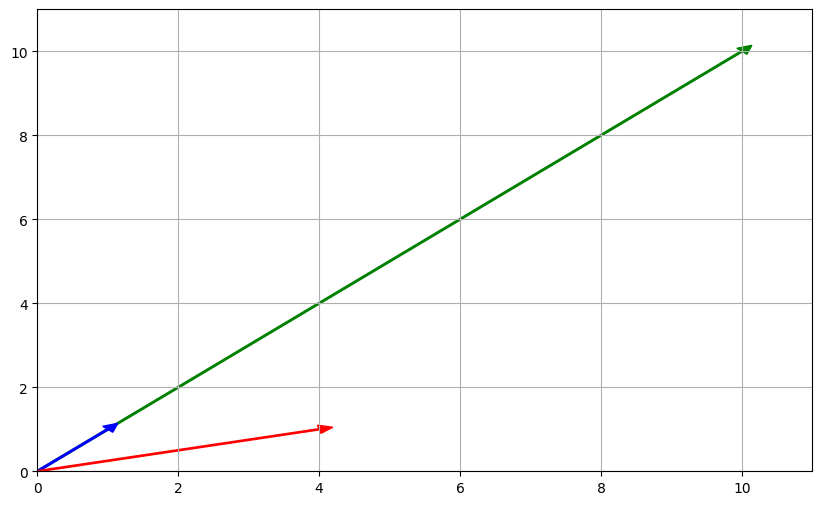

In [47]:
# зададим размер фигуры (контейнера, в который помещаются графики)
plt.figure(figsize = (10, 6))

# создадим объект графика внутри этой фигуры
ax = plt.axes()

# зададим диапазон осей x и y
plt.xlim([0, 11])
plt.ylim([0, 11])
plt.grid()

# нашими "подграфиками" будут два вектора в форме стрелок
ax.arrow(0, 0, x[0], x[1], width = 0.03, head_width = 0.2, head_length = 0.2, fc = 'g', ec = 'g')
ax.arrow(0, 0, y[0], y[1], width = 0.03, head_width = 0.2, head_length = 0.2, fc = 'b', ec = 'b')
ax.arrow(0, 0, z[0], y[1], width = 0.03, head_width = 0.2, head_length = 0.2, fc = 'r', ec = 'r')
plt.show()

Расчет косинусного сходства

In [29]:
# напишем функцию для расчета косинусного сходства
def similar(x, y):
    
    # рассчитаем длины векторов
    xLen = np.linalg.norm(x)
    yLen = np.linalg.norm(y)

    # подставим их в формулу косинусного сходства
    result = np.dot(x, y)/(xLen * yLen)
    
    # выведем результат
    return result

In [30]:
# ожидаемо косунус угла будет равен единице
round(similar(x, y), 3)

1.0

Сравнив по очереди x, y с z видим, что в этом случае появляется одинаковое различие 

In [48]:
round(similar(x, z), 3)

0.949

In [40]:
round(similar(y, z), 3)

0.949

Если у нас есть два фильма, которым все пользователи ставят рейтинги 10 и 1 соответственно, то мы сравниваем фильмы, а не пользователей (а значит это item-based, а не user-based система).

Как следствие, нужно посмотреть, что будет, если появится новый фильм, которому пользователи поставят оценки в 10 баллов. И вот здесь возникает справедливый вопрос, к какому из уже имеющихся в системе фильмов будет близок новый фильм с этими рейтингами?

Для решения этой задачи  построим простейшую item-based систему. Возьмем пять фильмов, пусть трем из них пользователи поставят разные оценки, а двум другим — только десятки и только единицы.

Item-based система

In [31]:
# создадим массив Numpy с оценками
films = np.array(
    [
     [1, 3, 2, 6, 2, 1, 0],
     [0, 2, 0, 3, 0, 6, 2],
     [1, 1, 1, 1, 1, 1, 1],
     [2, 4, 1, 3, 9, 2, 1],
     [10, 10, 10, 10, 10, 10, 10]
     ]
)

# строки это фильмы, столбцы - пользователи
films

array([[ 1,  3,  2,  6,  2,  1,  0],
       [ 0,  2,  0,  3,  0,  6,  2],
       [ 1,  1,  1,  1,  1,  1,  1],
       [ 2,  4,  1,  3,  9,  2,  1],
       [10, 10, 10, 10, 10, 10, 10]])

In [32]:
# предположим, вышел новый фильм, и все пользователи поставили ему рейтинг 10
new_film = np.array([10, 10, 10, 10, 10, 10, 10])

In [33]:
# в цикле for поочередно рассчитаем косинусное сходство каждого из имеющхся фильмов с новым фильмом
for i, film in enumerate(films, 1):
  print(f'Фильм {i} с оценками {film} имеет сходство с новым фильмом {np.round(similar(film, new_film), 3)}')

Фильм 1 с оценками [1 3 2 6 2 1 0] имеет сходство с новым фильмом 0.764
Фильм 2 с оценками [0 2 0 3 0 6 2] имеет сходство с новым фильмом 0.675
Фильм 3 с оценками [1 1 1 1 1 1 1] имеет сходство с новым фильмом 1.0
Фильм 4 с оценками [2 4 1 3 9 2 1] имеет сходство с новым фильмом 0.772
Фильм 5 с оценками [10 10 10 10 10 10 10] имеет сходство с новым фильмом 1.0


Система показала, что новый фильм одинаково близок как к фильму с рейтингами 1 от всех пользователей, так и к фильму с рейтингами 10. Конечно, это противоречит здравому смыслу.

На практике такая ситуация маловероятна, потому что мы работаем с матрицами с огромным количеством пользователей и фильмов. Вряд ли все пользователи поставят фильму одни и те же оценки. Однако, при создании коллаборативных систем возникает ряд сложностей.

О некоторых сложностях создания коллаборативных систем

Например, есть проблема разреженности (sparcity) матрицы предпочтений, когда многие пользователи не оставляют оценок, матрица заполняется нулями и от этого страдает качество рекомедаций (мы с этим столкнулись, в частности, в  учебной модели).

Кроме того, существует проблема холодного старта (cold start), когда либо (1) в системе в самом начале ее работы недостаточно данных для генерации рекомендаций, либо (2) пришел новый пользователь, который еще не ставил оценок, и система не знает, что ему посоветовать, либо (3) вышел новый фильм, книга, товар, которые пока не имеют рейтингов, и их схожесть с другими предметами рекомендации не так просто рассчитать.

Помимо этого, появление новых пользователей и новых фильмов вынуждают производить перерасчет расстояний в системе. Это всегда затратно с точки зрения вычислительных мощностей. В этом смысле, item-based система более удобна, чем user-based система, потому что фильмы, например, добавляются в систему реже, чем пользователи.